# Setup



In [83]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import io
import pandas as pd
######################################################################
# Setup python environment 
######################################################################
csv_path = '/content/drive/My Drive/Colab Notebooks/CSC413/Final Project/MovieData.csv'
md_df = pd.read_csv(csv_path)
md_df['movie_name'] = md_df['movie_name'].str.replace(" ", "+")
md_df_2 = md_df[['movie_name', 'production_year', 'production_budget', 'domestic_box_office', 'international_box_office', 'genre', 'running_time']]
# Dataset is now stored in a Pandas Dataframe

In [85]:
import requests
import json
from PIL import Image
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


api_key_auth3 = 'fad9ac13c7b36b3e05f6b63be16e74f0'

In [86]:
CUDA_LAUNCH_BLOCKING = "1"
import torch.nn as nn
import torch
from torch.utils.data import Dataset

In [87]:
from sklearn.preprocessing import OneHotEncoder

In [88]:
md_df_2.loc[md_df['movie_name'] == 'Brothers']

,movie_name,production_year,production_budget,domestic_box_office,international_box_office,genre,running_time
588,Brothers,2009,26000000,28544157,16499713,Drama,105.0
1495,Brothers,2015,13000000,656688,17200000,Action,155.0


In [89]:
md_df_2.groupby('movie_name').genre.nunique().sort_values(ascending = False)

movie_name
Brothers                                2
Home                                    2
10+Days+in+a+Madhouse                   1
Soul+Men                                1
Spider-Man:+Into+The+Spider-Verse+3D    1
                                       ..
Le+prénom                               0
The+Joneses                             0
Free+Style                              0
Haeundae                                0
Triangle                                0
Name: genre, Length: 1931, dtype: int64

# API Example

In [90]:
response = requests.get(f"https://api.themoviedb.org/3/search/movie?api_key={api_key_auth3}&query=Brothers")
response = response.json()

In [91]:
print(response['results'])

[{'adult': False, 'backdrop_path': '/zncDexWfEHrPVwvPGGbiVjbyabJ.jpg', 'genre_ids': [18, 53, 10752], 'id': 7445, 'original_language': 'en', 'original_title': 'Brothers', 'overview': 'When his helicopter goes down during his fourth tour of duty in Afghanistan, Marine Sam Cahill is presumed dead. Back home, brother Tommy steps in to look over Sam’s wife, Grace, and two children. Sam’s surprise homecoming triggers domestic mayhem.', 'popularity': 115.696, 'poster_path': '/ySXRgHCdelVtvUyHcKGpiQKb052.jpg', 'release_date': '2009-01-22', 'title': 'Brothers', 'video': False, 'vote_average': 7.307, 'vote_count': 2968}, {'adult': False, 'backdrop_path': '/7PzpnGL4W0oy1NAd0toIZeuDt0G.jpg', 'genre_ids': [16, 35, 14], 'id': 28152, 'original_language': 'ja', 'original_title': 'スーパーマリオブラザーズ ピーチ姫救出大作戦!', 'overview': 'When Princess Peach is kidnapped by the monster King Koopa, Mario and his brother Luigi journey to the Mushroom Kingdom to rescue her.', 'popularity': 596.847, 'poster_path': '/d8466YAgD

# Data Extraction

In [92]:
movie_titles = md_df['movie_name'].unique()
movie_titles

array(["Madea's+Family+Reunion", 'Krrish', 'End+of+the+Spear', ...,
       'Ralph+Breaks+The+Internet', 'Mission:+Impossible—Fallout',
       'Fantastic+Beasts:+The+Crimes+of+Grindelwald'], dtype=object)

Features:

- 22 Genres: Action, Adventure, Animation, Biography, Comedy, Crime, Documentary, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Sport, Thriller, War, and Western (binary vector of length 22)

- duration or running time (their analysis avg was 100min) https://developers.themoviedb.org/3/movies/get-movie-details

- production budget

- star value: number of likes for directos and top three performers in the cast
  1. https://developers.themoviedb.org/3/movies/get-movie-credits (By popular)
  2. https://developers.themoviedb.org/3/people/get-person-external-ids (Get fb id)
  3. https://developers.facebook.com/docs/graph-api/reference/v16.0/object/likes 

- Number of movie reviews https://developers.themoviedb.org/3/movies/get-movie-reviews

- Number of users who voted for a movie

- Avg movie score (0-10)


- Movie posters

Potential way of getting 3k most popular movies https://developers.themoviedb.org/3/movies/get-top-rated-movies


In [93]:
def get_movie_tmdb(movie_search):

  try:
    responses = requests.get(f"https://api.themoviedb.org/3/search/movie?api_key={api_key_auth3}&query={movie_search['movie_name']}")
    responses = responses.json()['results']
    
    for response in responses:
      if response['release_date'][0:4] ==  str(movie_search['production_year']):
        return pd.json_normalize(response)

    return pd.DataFrame()
  except:
    return pd.DataFrame()

def get_movie_details(movie_search, resize = transforms.Resize(size=256)):
  movie_tmdb_df = get_movie_tmdb(movie_search)

  if movie_tmdb_df.empty == False:

    addr = f"https://image.tmdb.org/t/p/w500{str(movie_tmdb_df['poster_path'][0])}"
    #poster_resp = requests.get(addr, stream=True).raw
    #poster = np.asarray(bytearray(poster_resp.read()), dtype="uint8")
    #movie_tmdb_df["poster"] = [poster]
    try:
      img = resize(Image.fromarray(io.imread(addr), 'RGB'))

    except:
      return pd.DataFrame()
    reshaped_arr_img = np.expand_dims(np.asarray(img), axis=0)
    movie_tmdb_df["poster"] = [reshaped_arr_img.tolist()]
    
    movie_id = movie_tmdb_df['id'][0]

    duration_responses = requests.get(f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key_auth3}&language=en-US")
    new_cols = pd.json_normalize(duration_responses.json())[['budget','revenue', 'runtime']]
    movie_tmdb_df[['budget','revenue', 'runtime']] = new_cols

    responses = requests.get(f"https://api.themoviedb.org/3/movie/{movie_id}/reviews?api_key={api_key_auth3}&language=en-US&page=1")
    new_cols = pd.json_normalize(responses.json())[['total_pages', 'total_results']]
    movie_tmdb_df[['total_pages', 'total_results']] = new_cols

    return movie_tmdb_df

  return pd.DataFrame()



In [94]:
transform = transforms.Resize(size=(150,150))
tens = transforms.ToTensor()

In [95]:
movie_search = md_df_2.iloc[1930]
md_df_2.iloc[1930]

movie_name                  Mary+Poppins+Returns
production_year                             2018
production_budget                      130000000
domestic_box_office                    171282866
international_box_office               175400000
genre                                    Musical
running_time                               130.0
Name: 1930, dtype: object

In [96]:
movies_df = get_movie_details(movie_search,transform)
movies_df = test.append(get_movie_details( md_df_2.iloc[1900], transform))

<ipython-input-96-14c196ba3136>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movies_df = test.append(get_movie_details( md_df_2.iloc[1900], transform))


In [97]:
for i in range(0,51):
  movie_row = get_movie_details( md_df_2.iloc[i], transform)

  if movie_row.empty == False:
      movies_df = movies_df.append(movie_row)

<ipython-input-97-a80159b8ed33>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movies_df = movies_df.append(movie_row)
<ipython-input-97-a80159b8ed33>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movies_df = movies_df.append(movie_row)
<ipython-input-97-a80159b8ed33>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movies_df = movies_df.append(movie_row)
<ipython-input-97-a80159b8ed33>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movies_df = movies_df.append(movie_row)
<ipython-input-97-a80159b8ed33>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [98]:
# Groups numerical revenue, currently 6 bins
num = [0,1,2,3,4,5]

revenue_in = pd.qcut(movies_df['revenue'], q=6, labels=num)

enc = OneHotEncoder().fit(np.array(revenue_in).reshape(-1,1))
df = pd.DataFrame(enc.transform(np.array(revenue_in).reshape(-1,1)).toarray())
df['combine'] = df.values.tolist()
movies_df['revenue_bin'] = df['combine']

In [99]:
movies_df.head(1)

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,...,vote_average,vote_count,poster,budget,revenue,runtime,total_pages,total_results,revenue_bin,output
0,False,/oGzToOBTRdXVOrHj8r0VgK3d2sU.jpg,"[14, 10751, 35]",400650,en,Mary Poppins Returns,Mary Poppins returns to the Banks family and h...,23.865,/uTVGku4LibMGyKgQvjBtv3OYfAX.jpg,2018-12-13,...,6.52,3012,"[[[[28, 117, 238], [29, 118, 236], [33, 123, 2...",130000000,348807090,131,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


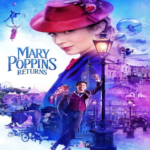

In [100]:
Image.fromarray(np.array(movies_df.iloc[0]['poster'][0]).astype(np.uint8))

In [101]:
torch.Tensor(np.vstack(movies_df['poster'].to_numpy())).shape

torch.Size([93, 150, 150, 3])

# DNN

## Dataset

In [102]:
feature_df = movies_df

In [103]:
feature_df = feature_df.loc[feature_df.index.repeat(2)]

In [104]:
print(feature_df.columns)
select_columns = ['popularity', 'budget', 'runtime', 'total_pages','total_results'] # 'genre_ids'
output_val = 'revenue_bin'

Index(['adult', 'backdrop_path', 'genre_ids', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'release_date', 'title', 'video', 'vote_average', 'vote_count',
       'poster', 'budget', 'revenue', 'runtime', 'total_pages',
       'total_results', 'revenue_bin', 'output'],
      dtype='object')


In [105]:
features_torch = torch.tensor(feature_df[select_columns].values).to(torch.float32)
features_torch #need to include genre which needs to be reshaped

tensor([[2.3865e+01, 1.3000e+08, 1.3100e+02, 1.0000e+00, 2.0000e+00],
        [1.4684e+01, 1.6000e+07, 1.0000e+02, 1.0000e+00, 1.0000e+00],
        [9.1040e+00, 6.0000e+06, 1.1000e+02, 0.0000e+00, 0.0000e+00],
        ...,
        [9.2720e+00, 2.0000e+07, 8.5000e+01, 0.0000e+00, 0.0000e+00],
        [1.7990e+01, 9.0000e+06, 8.5000e+01, 1.0000e+00, 1.0000e+00],
        [7.0020e+00, 2.0000e+07, 1.2300e+02, 0.0000e+00, 0.0000e+00]])

In [106]:
output_torch = torch.Tensor(np.vstack(feature_df[output_val].to_numpy()))
output_torch

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]])

In [107]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels, device):
        self.features = torch.tensor(features).to(torch.float32).to(device)
        self.labels = torch.Tensor(np.vstack(labels.to_numpy())) #torch.tensor(labels.astype('int32')).to(torch.float32).to(device)
        
        #self.num = torch.tensor(num).to(torch.float32).to(device)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        #rev = self.num[idx]
        '''
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        '''
        return features, label#, rev

## Model

In [108]:
from torchsummary import summary

In [109]:
input_dim = 6 - 1 #31?
num_features = input_dim
output_dim = 6
learn_rate_classification=5e-3
learn_rate_regression=5e-5

In [110]:
class DNN(nn.Module):
    def __init__(self, input_dim, num_features, output_dim = 6, dropout = 0.6):

        unit_1 = 72
        unit_2 = 128
        unit_3 = 256


        super().__init__()
        self.input_layer = nn.Linear(input_dim, num_features)

        self.layers = nn.Sequential(
            nn.Linear(num_features, unit_1),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout),

            nn.Linear(unit_1, unit_2),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout),

            nn.Linear(unit_2, unit_3),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout),

            nn.Linear(unit_3, unit_2),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout),

            nn.Linear(unit_2, unit_1),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout)
        )

        self.output_layer = nn.Sequential(
            nn.Linear(unit_1, output_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, features):
        x = self.input_layer(features)
        x = self.layers(x)
        x = self.output_layer(x)

        return x

In [111]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
test_DNN = DNN(input_dim, num_features, output_dim).to(device)
features_torch = features_torch.to(device)

In [112]:
batch_size = 50

train_dataset = FeatureDataset(feature_df[select_columns].values, feature_df[output_val], device)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)


criterion_classification = nn.CrossEntropyLoss()
criterion_regression = nn.MSELoss()
optimizer_classification = torch.optim.Adam(test_DNN.parameters(), lr=learn_rate_classification)
optimizer_regression = torch.optim.Adam(test_DNN.parameters(), lr=learn_rate_regression)

In [115]:
train_dataset.__getitem__(1) # Checking output

(tensor([1.4684e+01, 1.6000e+07, 1.0000e+02, 1.0000e+00, 1.0000e+00]),
 tensor([0., 0., 0., 0., 0., 1.]))

In [113]:
def accuracies(pred, label):
  num = label.shape[0]
  aphr_bingo = torch.sum(torch.all(pred.eq(label), dim = -1))/num

  zero_col = torch.zeros(size = [1,label.shape[-1]])

  shift_next = torch.roll(label, 1, -1)
  shift_next[:0] = zero_col

  shift_prev = torch.roll(label, -1, -1)
  shift_prev[:-1] = zero_col

  next_1 = torch.sum(torch.all(pred.eq(shift_next), dim = -1))
  prev_1 = torch.sum(torch.all(pred.eq(shift_prev), dim = -1))


  aphr_1_away = aphr_bingo + next_1/num + prev_1/num

  return aphr_bingo, aphr_1_away

In [116]:
acc_aphr_bingo = np.array([])
acc_aphr_1_away = np.array([])

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(data)

        # zero the parameter gradients
        optimizer_classification.zero_grad()

        # forward + backward + optimize
        outputs = test_DNN(inputs)
        #print(labels, outputs)
        loss = criterion_classification(outputs, labels)
        #outputs_detach = outputs.detach()
        #outputs_detach.requires_grad = True
        loss.backward(retain_graph=True)
        optimizer_classification.step()

        # # zero the parameter gradients
        # optimizer_regression.zero_grad()

        # # forward + backward + optimize
        # loss = criterion_regression(outputs, rev)
        # loss.backward()
        # optimizer_regression.step()

        aphr_bingo, aphr_1_away = accuracies(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 5 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] aphr_bingo: {aphr_bingo:.3f} aphr_1_away: {aphr_1_away:.3f}')
            running_loss = 0.0
            acc_aphr_bingo = np.append(acc_aphr_bingo, aphr_bingo)
            acc_aphr_1_away = np.append(acc_aphr_1_away, aphr_1_away)
        

print('Finished Training')

[1,     5] loss: 0.004
[1,     5] aphr_bingo: 0.800 aphr_1_away: 0.860
[1,    10] loss: 0.003
[1,    10] aphr_bingo: 0.860 aphr_1_away: 0.860
[1,    15] loss: 0.003
[1,    15] aphr_bingo: 0.920 aphr_1_away: 0.920
[1,    20] loss: 0.003
[1,    20] aphr_bingo: 0.960 aphr_1_away: 0.960
[1,    25] loss: 0.003
[1,    25] aphr_bingo: 0.980 aphr_1_away: 0.980
[1,    30] loss: 0.003
[1,    30] aphr_bingo: 0.960 aphr_1_away: 0.960
[1,    35] loss: 0.003
[1,    35] aphr_bingo: 0.960 aphr_1_away: 0.960
[1,    40] loss: 0.003
[1,    40] aphr_bingo: 0.980 aphr_1_away: 0.980
[1,    45] loss: 0.003
[1,    45] aphr_bingo: 0.900 aphr_1_away: 0.900
[1,    50] loss: 0.003
[1,    50] aphr_bingo: 0.980 aphr_1_away: 0.980
[1,    55] loss: 0.003
[1,    55] aphr_bingo: 0.960 aphr_1_away: 0.960
[1,    60] loss: 0.003
[1,    60] aphr_bingo: 0.980 aphr_1_away: 0.980
[1,    65] loss: 0.003
[1,    65] aphr_bingo: 0.960 aphr_1_away: 0.960
[1,    70] loss: 0.003
[1,    70] aphr_bingo: 0.960 aphr_1_away: 0.960
[1,   

Todo:
- Dataset: Right now just concat (also need regularization)
  - "In the multimodal prediction model, the dimension reduction was achieved by fully connected layers. In particular, data of dimension larger than one (e.g., movie genres) was reduced to 1." How?
- Model evaluation
- Questions:
  - "To train this network, discretized movie box-office revenues are adopted. For each input data modality, the training can be conducted separately, and then the pre-trained model can be incorporated to utilize features from multimodal data." ???


- Notes:
  - "To regularize the training of the multimodal DNN, the original numerical and discretized form of movie box-office revenues were both adopted as output, and parameters of the multimodal DNN were updated according to the cost functions of these two outputs."

  - "activation of nth sample in the output layer"

# CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), padding = 0),
            nn.ReLU(),   
            nn.MaxPool2d(2,2)

        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
c = CNN()
x = torch.Tensor(np.vstack(test['poster'].to_numpy()))

x = torch.transpose(x, -1, 1).transpose(2,3)

In [ ]:
x.shape

In [ ]:
c.forward(x).shape